In [27]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates
%matplotlib inline

In [28]:
page = requests.get("https://www.ndbc.noaa.gov/station_page.php?station=46237")
soup = BeautifulSoup(page.content, 'lxml')

#last 45 days : https://www.ndbc.noaa.gov/data/realtime2/46237.txt



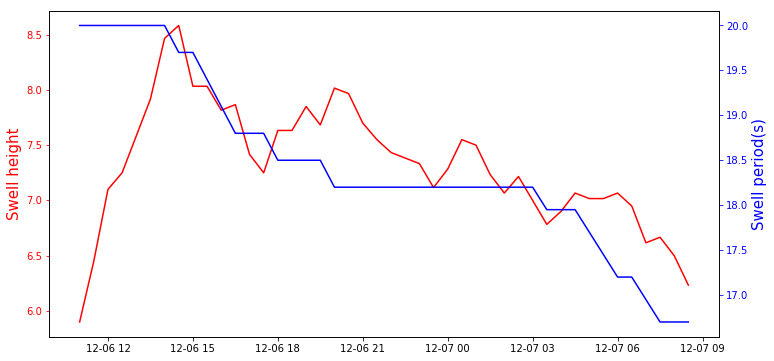

In [29]:
table = soup.find_all('table')[10] 
df = pd.read_html(str(table))
df = df[0]

df.columns = df.loc[1].values
df.drop([0,1], inplace = True)

df['Time'] = df['MM'] + ' '+ df['DD']+ ' ' + df['TIME(PST)']
df = df.apply(pd.to_numeric, errors='ignore')

df['Time'] = pd.to_datetime (df['Time'], format = "%m %d %I:%M %p" )
df =df.set_index(df['Time'])


fig, ax1 = plt.subplots(figsize=(12,6))
    
ax1.plot(df['SwHft'].rolling(6).mean(), color = 'r');
ax1.set_ylabel('Swell height', color='r', size=15)
ax1.tick_params('y', colors='r')

ax2 = ax1.twinx()
ax2.plot(df['SwPsec'].rolling(6).mean(), color ='b');
ax2.set_ylabel('Swell period(s)', color='b', size=15)
ax2.tick_params('y', colors='b')

In [7]:
now = datetime.datetime.now()
begindate = now.strftime("%Y%m%d")
enddate = datetime.datetime.now() + datetime.timedelta(days=1)
enddate = enddate.strftime("%Y%m%d")


In [8]:
#get tides
url = 'https://tidesandcurrents.noaa.gov/api/datagetter?product=predictions&application=NOS.COOPS.TAC.WL&begin_date=' + begindate + '&end_date=' + begindate +'&datum=MLLW&station=9414290&time_zone=lst_ldt&units=english&interval=6&format=json'
#url = 'https://tidesandcurrents.noaa.gov/api/datagetter?product=predictions&application=NOS.COOPS.TAC.WL&begin_date=20181201&end_date=20181231&datum=MLLW&station=9414290&time_zone=lst_ldt&units=english&interval=6&format=json'
page = requests.get(url)
tides = pd.DataFrame(page.json()['predictions'])
    
    

tides['t'] = pd.to_datetime(tides['t'])
tides.set_index('t')
tides.head()

,t,v
0,2018-12-06 00:00:00,4.645
1,2018-12-06 00:06:00,4.597
2,2018-12-06 00:12:00,4.544
3,2018-12-06 00:18:00,4.487
4,2018-12-06 00:24:00,4.425


In [9]:
tides = tides.set_index('t')
tides['v'] = pd.to_numeric(tides['v'])
#tides.info()


Text(0.5,0,'Height (fts)')

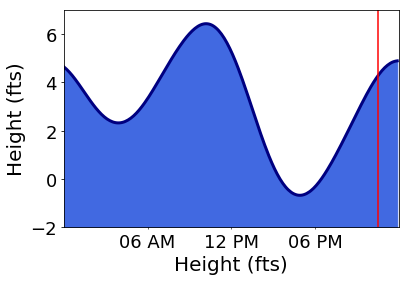

In [10]:
toplot = tides[:]['v']


fig, ax = plt.subplots()

ax.plot(toplot.index, toplot.values, linewidth =3, color = 'navy');
plt.ylabel('Height (fts)', size=20)

#have to change that
ax.set_xlim(begindate, enddate)
ax.set_ylim(-2,7)


ax.fill_between(toplot.index, toplot.values, -2, color="royalblue")
#ax2.fill_between(x, y1, 1)
ax.axvline(datetime.datetime.now(), color='r');

hourlocator = matplotlib.dates.HourLocator(byhour=[6,12,18])
ax.xaxis.set_minor_locator(hourlocator)   # every 4 hours
ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter('%I %p'))  # hours and minutes

ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('\n%d-%b')) 

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)

plt.xlabel('Height (fts)', size=20)

In [11]:
now.strftime("%m %d %Y")

'12 06 2018'

In [12]:
#Swell and forecast

#polar.ncep.noaa.gov/waves/WEB/multi_1.latest_run/plots/multi_1.46237.bull

forecast = requests.get("http://polar.ncep.noaa.gov/waves/WEB/multi_1.latest_run/plots/multi_1.46237.bull")


In [13]:
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
x =forecast.text
y = StringIO(x)
Forecast =pd.read_csv(y, sep="|", skiprows=4)

In [14]:
Forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 10 columns):
                       201 non-null object
 day &                 191 non-null object
  Hst  n x             191 non-null object
    Hs   Tp  dir       191 non-null object
    Hs   Tp  dir .1    191 non-null object
    Hs   Tp  dir .2    191 non-null object
    Hs   Tp  dir .3    191 non-null object
    Hs   Tp  dir .4    191 non-null object
    Hs   Tp  dir .5    191 non-null object
Unnamed: 9             0 non-null float64
dtypes: float64(1), object(9)
memory usage: 15.8+ KB


In [15]:
#Forecast.drop(Forecast.columns[0], axis=1)

<h1>BUOYS</h1>|

In [16]:
Bouy = pd.read_csv('https://www.ndbc.noaa.gov/data/realtime2/46237.spec', delim_whitespace=True)
#Bouy.head()
Bouy = Bouy.drop([0])
#to_drop =['WDIR','WSPD','GST', 'PRES','ATMP', 'DEWP','VIS', 'PTDY','TIDE']
#Bouy = Bouy.drop(to_drop, axis=1)
Bouy.head()

,#YY,MM,DD,hh,mm,WVHT,SwH,SwP,WWH,WWP,SwD,WWD,STEEPNESS,APD,MWD
1,2018,12,07,06,00,2.4,2.3,18.2,0.8,9.5,W,W,SWELL,14.2,267
2,2018,12,07,05,30,2.6,2.5,18.2,0.9,9.1,W,W,SWELL,14.4,268
3,2018,12,07,05,00,2.4,2.3,18.2,0.8,9.1,W,W,SWELL,14.1,263
4,2018,12,07,04,30,2.7,2.6,18.2,0.9,9.5,W,W,SWELL,14.6,270
5,2018,12,07,04,00,2.6,2.5,18.2,0.8,9.5,W,W,SWELL,14.8,269


In [17]:
#Bouy.to_csv ('bouy.csv')

In [18]:
#Bouy = pd.read_csv('bouy.csv')


Bouy['Time'] = Bouy['#YY'].astype(str) + ' '+ Bouy['MM'].astype(str)+ ' ' + Bouy['DD'].astype(str) + ' '+ Bouy['hh'].astype(str)+ ' ' + Bouy['mm'].astype(str)
Bouy = Bouy.apply(pd.to_numeric, errors='ignore')
Bouy['Time'] = pd.to_datetime (Bouy['Time'], format = "%Y %m %d %H %M" )
Bouy =Bouy.set_index(Bouy['Time'])

#Bouy.head(20)


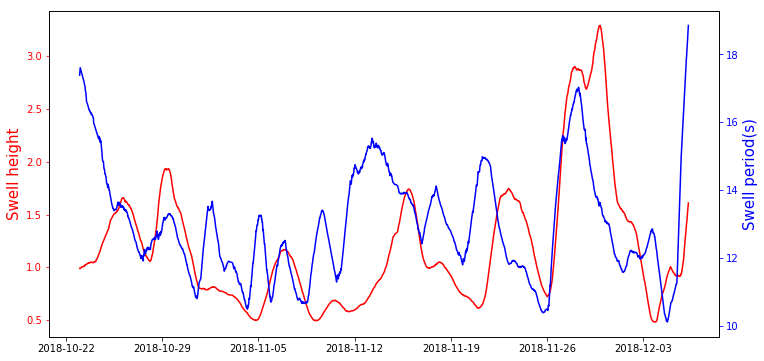

In [19]:
fig, ax1 = plt.subplots(figsize=(12,6))
    
ax1.plot(Bouy['SwH'].rolling(48).mean(), color = 'r');
ax1.set_ylabel('Swell height', color='r', size=15)
ax1.tick_params('y', colors='r')

ax2 = ax1.twinx()
ax2.plot(Bouy['SwP'].rolling(48).mean(), color ='b');
ax2.set_ylabel('Swell period(s)', color='b', size=15)
ax2.tick_params('y', colors='b')